In [1]:
import numpy as np
import scipy as sp
import os
from scipy import io,integrate,sparse
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset


from lanczos_bin import *

from IPython.display import clear_output
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['text.latex.preamble'] = r'\renewcommand{\vec}{\mathbf}'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [3]:
os.makedirs("data/wass", exist_ok=True)

In [4]:
problems = [{'name':'California',
             'Ks':np.unique(np.logspace(1,np.log10(1200),15,dtype='int')),
             'n_samples':6,
            },
            {'name':'Erdos992',
             'Ks':np.unique(np.logspace(1,np.log10(800),15,dtype='int')),
             'n_samples':9,
            },
            {'name':'MNIST_cov',
             'Ks':np.unique(np.logspace(1,np.log10(500),15,dtype='int')),
             'n_samples':68
            },
            {'name':'uniform',
             'Ks':np.unique(np.logspace(1,np.log10(200),15,dtype='int')),
             'n_samples':11
            },]

In [5]:
# generate data
if True:
    for problem in problems:

        name = problem['name']
        n_samples = problem['n_samples']
        Ks = problem['Ks']

        lam = np.load(f"matrices/{name}_eigs.npy")
        
        print(name)
        np.save(f'data/wass/{name}_GQs',get_GQs(lam,n_samples,Ks,reorth=True),allow_pickle=True)

California
Erdos992
MNIST_cov
uniform


In [6]:
# generate bounds
if True:
    for problem in problems:

        name = problem['name']
        lam = np.load(f"matrices/{name}_eigs.npy")

        GQs,vs = np.load(f'data/wass/{name}_GQs.npy',allow_pickle=True)

        print(name)
        np.save(f'data/wass/{name}',W_experiment(GQs,lam,vs,np.min(lam),np.max(lam)),allow_pickle=True)

California
Erdos992
MNIST_cov
uniform


In [7]:
# parse resnet example
Ks = np.logspace(1,np.log10(3000),15,dtype='int')

n_samples = 2

GQ = {k:[] for k in Ks}
GQ_lower = {k:[] for k in Ks}
GQ_upper = {k:[] for k in Ks}

for trial in range(n_samples):
    a_,b_ = np.load(f'data/resnet20_cifar10_3000_{trial}.npy',allow_pickle=True)

    for k in Ks:
        GQ[k].append(get_GQ_distr(a_[:k],b_[:k-1]))
        lb,ub = np.min(GQ[k][-1].support),np.max(GQ[k][-1].support)
        
        # define upper and lower bounds
        GQ_lower[k].append(get_GQ_lower_bound(GQ[k][-1],lb,ub))
        GQ_upper[k].append(get_GQ_upper_bound(GQ[k][-1],lb,ub))

GQ_ave = {}
GQ_lower_ave = {}
GQ_upper_ave = {}

for k in Ks:
   # average bounds
    GQ_ave[k] = get_ave_distr(GQ[k])
    GQ_lower_ave[k] = get_ave_distr(GQ_lower[k])
    GQ_upper_ave[k] = get_ave_distr(GQ_upper[k]) 

t_W_bd = np.array([d_Wbd(GQ_ave[k],-5.8,189.5) for k in Ks])

np.save(f'data/wass/resnet20',[n_samples,Ks,-1,t_W_bd,GQ_ave],allow_pickle=True)

6
9
68
11


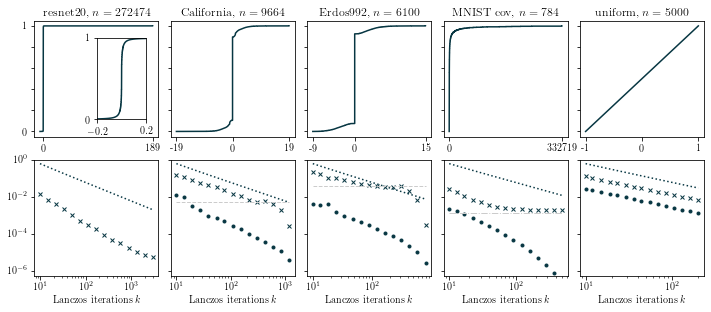

In [8]:
fig,axs = plt.subplots(2,5,figsize=(12,4.7),sharey='row')
fig.subplots_adjust(wspace=.1)

# resnet20 example
name='resnet20'
n = 272474
n_samples,Ks,_,t_W_bd,GQ_ave = np.load(f'data/wass/{name}.npy',allow_pickle=True)

axs[0,0].step(*GQ_ave[3000].get_distr(),where='post',color='#073642')
axs[0,0].set_title(f"{name.replace('_',' ')}, $n={n}$")#, $n_v={n_samples}$")

axins = inset_axes(axs[0,0], "40%","70%", loc='right', borderpad=1.2) # zoom = 6
axins.step(*GQ_ave[3000].get_distr(),where='post',color='#073642')


# sub region of the original image
x1, x2, y1, y2 = -.2,.2,0,1
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

axins.set_yticks([0,1])
axins.set_xticks([x1,x2])

ticks = np.unique([0,np.max(GQ_ave[3000].support)])
axs[0,0].set_xticks(ticks)
axs[0,0].set_xticklabels([f'{t:1.0f}' for t in ticks])


axs[1,0].plot(Ks,12/(2*Ks-1),linestyle=':',color='#073642')
axs[1,0].plot(Ks,t_W_bd/(GQ_ave[3000].support[-1]-GQ_ave[3000].support[0]),linestyle='None',marker='x',ms=4,color='#073642')
axs[1,0].set_xscale('log')
axs[1,0].set_yscale('log')

axs[1,0].set_xlabel(f'Lanczos iterations $k$')

# full spectrum examples
for i,problem in enumerate(problems):
    
    i+=1
    name = problem['name']
    lam = np.load(f"matrices/{problem['name']}_eigs.npy")

    n = len(lam)
    A = sp.sparse.spdiags(lam,0,n,n)
    
    lb = np.min(lam)
    ub = np.max(lam)
    
    # plot spectrum
    axs[0,i].step(lam,np.arange(n)/n,where='post',color='#073642')
    axs[0,i].set_title(f"{name.replace('_',' ')}, $n={n}$")#, $n_v={n_samples}$")
    
    ticks = np.unique([np.min(lam),0,np.max(lam)])
    axs[0,i].set_xticks(ticks)
    axs[0,i].set_xticklabels([f'{t:1.0f}' for t in ticks])

    # load data
    n_samples,Ks,t_W,t_W_bd = np.load(f'data/wass/{name}.npy',allow_pickle=True)
    print(n_samples)
    
    # plot ub
    axs[1,i].plot(Ks,12/(2*Ks-1),linestyle=':',color='#073642')
    
    # plot GQ
    axs[1,i].plot(Ks,t_W/(np.max(lam) - np.min(lam)),linestyle='None',marker='.',color='#073642')

    # plot GQ_bound
    axs[1,i].plot(Ks,t_W_bd/(np.max(lam) - np.min(lam)),linestyle='None',marker='x',ms=4,color='#073642')


    # plot stagnations
    if i in [1,2]:
        stagnate = (np.min(lam[lam>1e-10])-np.max(lam[lam<-1e-10]))
        stagnate *= np.sum(np.abs(lam)<1e-10)/len(lam)/(np.max(lam) - np.min(lam))
        axs[1,i].plot([min(Ks),max(Ks)],[stagnate]*2,linewidth=1,linestyle='--',color='#cccccc')
    
    if i == 3:
        stagnate = 1/n
        axs[1,i].plot([min(Ks),max(Ks)],[stagnate]*2,linewidth=1,linestyle='-.',color='#cccccc')
    
    
    axs[1,i].set_xscale('log')
    axs[1,i].set_yscale('log')

    axs[1,i].set_xlabel(f'Lanczos iterations $k$')

axs[0,0].set_yticks([0,.2,.4,.6,.8,1])
axs[0,0].set_yticklabels([0,'','','','',1])

axs[1,0].set_yticks([1,1e-2,1e-4,1e-6])
axs[1,0].set_ylim(5e-7,1)


plt.savefig('imgs/tW_bounds.pdf',bbox_inches='tight')